<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-01-19 16:03:54--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-01-19 16:03:54 (178 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

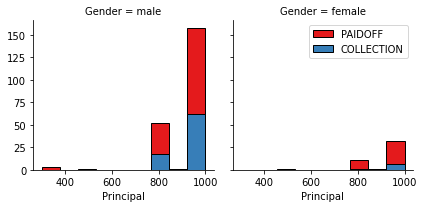

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

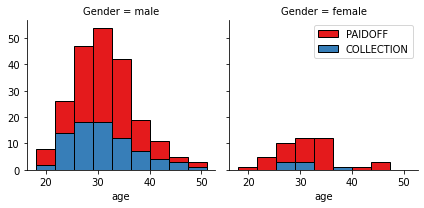

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


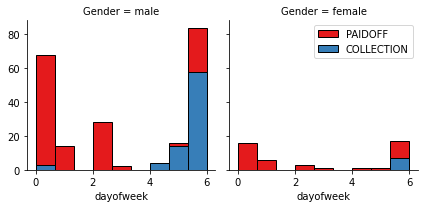

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
#first 5 rows of dataset 
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [139]:
# Import the library for splitting the data into train and test set
from sklearn.model_selection import train_test_split

#split into training and test set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

#importing methods for classification and clustering for KNN model
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score

ks = range(1, 10)
mean_accuracy = []

#finding best value for K
for n in ks:
    knn_model  = knn(n_neighbors = n)
    knn_model.fit(X_train, y_train)
    knn_yhat = knn_model.predict(X_test)
    mean_accuracy.append(accuracy_score(y_test, knn_yhat))

In [143]:
for i in range(0, len(mean_accuracy)):
    print("k = {} has a Score = {} ".format(i+1, mean_accuracy[i].round(2)))

k = 1 has a Score = 0.67 
k = 2 has a Score = 0.66 
k = 3 has a Score = 0.71 
k = 4 has a Score = 0.69 
k = 5 has a Score = 0.76 
k = 6 has a Score = 0.71 
k = 7 has a Score = 0.79 
k = 8 has a Score = 0.76 
k = 9 has a Score = 0.76 


Text(0, 0.5, 'Test: Accuracy Values')

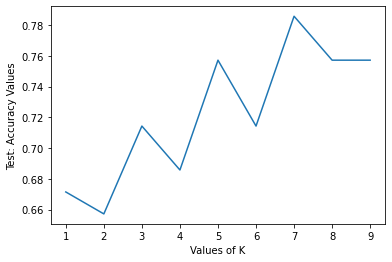

In [144]:
# Relation between k and their accuracies
plt.plot(ks, mean_accuracy)
plt.xlabel('Values of K')
plt.ylabel('Test: Accuracy Values')

In [145]:
#building final model for KNN

knn_model = knn(n_neighbors = 7).fit(X_train, y_train)
knn_yhat = knn_model.predict(X_test)
knn_model

KNeighborsClassifier(n_neighbors=7)

In [165]:
#using model to predict test set
knn_yhat = knn_model.predict(X_test)
knn_yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [166]:
# Importing the metrics
from sklearn import metrics
#finding accuracy of test and train
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn_model.predict(X_train)).round(2))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, knn_yhat).round(2))

Train set Accuracy:  0.81
Test set Accuracy:  0.79


In [167]:
#Building the confusion matrix for specifics  
from sklearn.metrics import classification_report

print (classification_report(y_test, knn_yhat))

              precision    recall  f1-score   support

  COLLECTION       0.50      0.40      0.44        15
     PAIDOFF       0.84      0.89      0.87        55

    accuracy                           0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70



In [168]:
from sklearn.metrics import f1_score
f1_score(y_test, knn_yhat, average='weighted').round(2)

0.78

In [169]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, knn_yhat, average='weighted').round(2)

0.66

Conclusion: KNN is a supervised machine learning model with a goal of clustering based on similar measurements, determined by distance functions. This modeling can be used for classification and/or regression. First, I created a test and training set to split the data. I calculated the best fitting k value and its' correlating mean accuracy. K=7 because this mean accuracy was the closest to 1, which indicates this training sample was the closest to the test sample. After determining the best value for K, the train set was used to find the nearest neighbors. With the train set accuracy being 0.81 and test set being 0.79, the accuracies are only off by 0.02. The f score, which recalls the precision and accuracy of the model, and jacquard similarity score, used to measure similarity and diversity of score, were both high. 

# Decision Tree


In [170]:
# Import the decision tree model
from sklearn.tree import DecisionTreeClassifier

In [171]:
for d in range(1,10):
    dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = d).fit(X_train, y_train)
    dt_yhat = dt.predict(X_test)
    print("For depth = {}  the accuracy score is {} ".format(d, accuracy_score(y_test, dt_yhat).round(2)))

For depth = 1  the accuracy score is 0.79 
For depth = 2  the accuracy score is 0.79 
For depth = 3  the accuracy score is 0.61 
For depth = 4  the accuracy score is 0.61 
For depth = 5  the accuracy score is 0.64 
For depth = 6  the accuracy score is 0.77 
For depth = 7  the accuracy score is 0.76 
For depth = 8  the accuracy score is 0.76 
For depth = 9  the accuracy score is 0.66 


In [172]:
# creating model for decision tree with max depth 2
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2).fit(X_train, y_train)
dt_model

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [173]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, best_dt_model.predict(X_train)).round(2))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat).round(2))

Train set Accuracy:  0.74
Test set Accuracy:  0.66


In [174]:
# Calculate the F1 score
f1_score(y_test, yhat, average='weighted').round(2)

0.68

In [175]:
jaccard_score(y_test, knn_yhat, average='weighted').round(2)

0.66

Conclusion: The decision tree is used as a support tool which creates a visual model of decisions and their possible consequences. The algorithm is one way to visually display only conditional control statements. By using the previous train and test sets, I first built the decision tree model, trained the model with maximum depth ranging from 1-10, and calculated the accuracy of each model. The max depth of 2 was chosen due to the ablity to show patterns and fluctuations better than other values. The models were extremely close in accuracy.  

# Support Vector Machine


In [176]:
#importing svm
from sklearn import svm 
from sklearn.metrics import f1_score

In [177]:
# Import the library for SVM Classifier
from sklearn import svm

# Build a SVM Classifier with a Radial base Function Kernel
loansvm1 = svm.SVC(kernel='rbf').fit(X_train, y_train)
yhat1 = loansvm1.predict(X_test)
svm_r = metrics.accuracy_score(y_test, yhat1).round(2)

# Build a SVM Classifier with a Linear Kernel
loansvm2 = svm.SVC(kernel='linear').fit(X_train, y_train)
yhat2 = loansvm2.predict(X_test)
svm_l = metrics.accuracy_score(y_test, yhat2).round(2)
    
# Build a SVM Classifier with a Polynomial Kernel
loansvm3 = svm.SVC(kernel='poly').fit(X_train, y_train)
yhat3 = loansvm3.predict(X_test)
svm_p = metrics.accuracy_score(y_test, yhat3).round(2)

# Build a SVM Classifier with a Sigmoid Kernel
loansvm4 = svm.SVC(kernel='sigmoid').fit(X_train, y_train)
yhat4 = loansvm4.predict(X_test)
svm_s = metrics.accuracy_score(y_test, yhat4).round(2)
    
print("Rbf: ", svm_r, "\nLiblinear: ", svm_l, "\nPolynomial: ", svm_p, "\nSigmoid: ", svm_s)

Rbf:  0.74 
Liblinear:  0.79 
Polynomial:  0.77 
Sigmoid:  0.74


In [188]:
# build svm with a linear kernel
svm_model = svm.SVC(kernel='rbf').fit(X_train, y_train)
smv_yhat=yhat2 = loansvm2.predict(X_test)

In [189]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, svm_model.predict(X_train)).round(2))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat).round(2))

Train set Accuracy:  0.78
Test set Accuracy:  0.69


In [190]:
f1_score(y_test, yhat, average='weighted').round(2)

0.67

In [191]:
jaccard_score(y_test, yhat, average='weighted').round(2)

0.55

Conclusion: This is a supervised machine learning model that analyzes data through methods for classification, regression and outlier detection. By using the previous test and train sets, I ran the 4 kernels in order to identify which would be the best to use. With the linear kernel being the highest, I built the model and tested the accuracy of each model.  

# Logistic Regression


In [192]:
# importing libraries
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss

for k in ('lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag'):
    lr_model = LogisticRegression(C = 0.01, solver = k).fit(X_train, y_train)
    lr_yhat = lr_model.predict(X_test)
    y_prob = lr_model.predict_proba(X_test)
    print('When Solver is {}, logloss is : {}'.format(k, log_loss(y_test, y_prob).round(2)))


When Solver is lbfgs, logloss is : 0.49
When Solver is saga, logloss is : 0.49
When Solver is liblinear, logloss is : 0.58
When Solver is newton-cg, logloss is : 0.49
When Solver is sag, logloss is : 0.49


In [193]:
#implementing liblinear 
loanlr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
lr_yhat = loanlr.predict(X_test)

In [194]:
#creating best logistic regression model with liblinear solver
lr_model = LogisticRegression(C = 0.01, solver = 'liblinear').fit(X_train, y_train)
lr_model

LogisticRegression(C=0.01, solver='liblinear')

In [195]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanlr.predict(X_train)).round(2))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat).round(2))

Train set Accuracy:  0.76
Test set Accuracy:  0.69


In [196]:
f1_score(y_test, yhat, average='weighted').round(2)

0.67

In [197]:
jaccard_score(y_test, yhat, average='weighted').round(2)

0.55

Conclusion: The logistic model is used to statistically measure relationships, but in a binary ratio. First, I once again tested different kernels to find the most appropriate. Then, I created the model and checked for accuracy. 

# Model Evaluation using Test set


In [198]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [199]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-01-19 16:56:15--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-01-19 16:56:15 (108 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [200]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [201]:
# shape of the test data set 
test_df.shape

(54, 10)

In [202]:
# Count of the loan status 
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [203]:
df = test_df

df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

df.groupby(['education'])['loan_status'].value_counts(normalize=True)

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X_test = Feature

y_test = df['loan_status'].values

X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

In [223]:
# Jaccard

# KNN
knn_yhat = knn_model.predict(X_test)
jacc1 = jaccard_score(y_test, knn_yhat, average='weighted').round(2)

# Decision Tree
dt_yhat = dt_model.predict(X_test)
jacc2 = jaccard_score(y_test, dt_yhat, average='weighted').round(2)

# Support Vector Machine
svm_yhat = svm_model.predict(X_test)
jacc3 = jaccard_score(y_test, svm_yhat, average='weighted').round(2)

# Logistic Regression
lr_yhat = lr_model.predict(X_test)
jacc4 = jaccard_score(y_test, lr_yhat, average='weighted').round(2)

jss_list = [jacc1, jacc2, jacc3, jacc4]
print("For Jaccard Similarity Score: ", "\nKnn: ", jacc1, "\nDecision Tree: ", jacc2, "\nSupport Vector Machine: ", jacc3, "\nLogistic Regression: ", jacc4
)

For Jaccard Similarity Score:  
Knn:  0.51 
Decision Tree:  0.55 
Support Vector Machine:  0.65 
Logistic Regression:  0.56


In [224]:
# F1

# KNN
knn_yhat = knn_model.predict(X_test)
jacc1 = f1_score(y_test, knn_yhat, average='weighted').round(2)

# Decision Tree
dt_yhat = dt_model.predict(X_test)
jacc2 = f1_score(y_test, dt_yhat, average='weighted').round(2)

# Support Vector Machine
svm_yhat = svm_model.predict(X_test)
jacc3 = f1_score(y_test, svm_yhat, average='weighted').round(2)

# Logistic Regression
lr_yhat = lr_model.predict(X_test)
jacc4 = f1_score(y_test, lr_yhat, average='weighted').round(2)

f1_list = [jacc1, jacc2, jacc3, jacc4]
print("For F1 Score: ", "\nKnn: ", jacc1, "\nDecision Tree: ", jacc2, "\nSupport Vector Machine: ", jacc3, "\nLogistic Regression: ", jacc4
)

For F1 Score:  
Knn:  0.63 
Decision Tree:  0.63 
Support Vector Machine:  0.76 
Logistic Regression:  0.66


In [227]:
# log loss
# Logistic Regression
lr_prob = lr_model.predict_proba(X_test)
logLoss_list= ['NA','NA','NA', round(log_loss(y_test, lr_prob), 2)]
logLoss_list

['NA', 'NA', 'NA', 0.57]

In [229]:
columns = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
index = ['Jaccard', 'F1-score', 'Logloss']

accuracy_df = pd.DataFrame([jss_list, f1_list, logLoss_list], index = index, columns = columns)
accuracy_df1 = accuracy_df.transpose()
accuracy_df1.columns.name = 'Algorithm'
accuracy_df1

Algorithm,Jaccard,F1-score,Logloss
KNN,0.51,0.63,NA
Decision Tree,0.55,0.63,NA
SVM,0.65,0.76,NA
Logistic Regression,0.56,0.66,0.57


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
